In [3]:
## Load and explore all samples from Chen_c

In [4]:
d = '/storage/groups/ml01/datasets/projects/20210318_retinal_data_integration_ignacio.ibarra_malte.luecken/Chen_c'

In [5]:
import scanpy as sc
import os

In [6]:
# convert counts into float32
# Convenience method for computing the size of objects
def print_size_in_MB(x):
    print('{:.3} MB'.format(x.__sizeof__()/1e6))

### Use the scran related directory to map all the files we need to put together.
datadir_orig = '/storage/groups/ml01/datasets/projects/20210318_retinal_data_integration_ignacio.ibarra_malte.luecken'
datadir_scran = '/mnt/znas/icb_zstore01/groups/ml01/workspace/ignacio.ibarra/theislab/retinal_scRNAseq_integration/data/integration_march_2021/scran'
filenames = [f for f in os.listdir(datadir_orig)]
filenames_md5 = [f.strip() for f in open(os.path.join(datadir_orig, 'md5sum.txt'))]

files = set()
for qi in filenames_md5:
    md5, fi = qi.split('  ')
    # print(fi)
    found = os.path.exists(os.path.join(datadir_scran, fi))
    if not found:
        print('not found', fi)
    files.add(fi)

# **The following files are listed but for some reason not found anymore. Consider deleting (Request to Jin first)**

filenames_by_dataset = {}
for f in filenames_md5:
    dataset, filename = f.split(' ')[-1].split('/')[-2:]
    if not dataset in filenames_by_dataset:
        filenames_by_dataset[dataset] = []
    filenames_by_dataset[dataset].append(filename)


In [7]:
filenames_by_dataset['Chen_c']

['10x3_19_D008.h5ad',
 '10x3_D019_13.h5ad',
 '10x3_19_D010.h5ad',
 '10x3_D027_13.h5ad',
 '10x3_19_D019.h5ad',
 '10x3_D005_13.h5ad',
 '10x3_D009_13.h5ad',
 '10x3_D026_13.h5ad',
 '10x3_19_D005.h5ad',
 '10x3_19_D009.h5ad',
 '10x3_D018_13.h5ad',
 '10x3_19_D011.h5ad',
 '10x3_19_D003.h5ad',
 '10x3_D028_13.h5ad',
 '10x3_19_D007.h5ad',
 '10x3_D030_13.h5ad',
 '10x3_D017_13.h5ad',
 '10x3_D013_13.h5ad',
 '10x3_D021_13.h5ad',
 '10x3_19_D006.h5ad']

In [8]:
# get all files from a single directory
def get_by_dataset(dataset_name, filenames=None, n_sample=None):
    adatas = []
    
    if (filenames is None):
        filenames = [f for f in listdir(join(datadir_scran, dataset_name))]
    print('# datasets', len(filenames))
    for f in filenames:
        if len(adatas) % 20 == 0:
            print('loaded so far', len(adatas))
        p = join(datadir_scran, dataset_name, f)
        print(p)
        ad = sc.read_h5ad(p)
        
        if n_sample is not None:
            idx_sample = ad.obs.sample(n_sample if n_sample < ad.shape[0] else ad.shape[0]).index
            ad = ad[ad.obs.index.isin(idx_sample),:]
            # print(ad.shape)        
        
        ad.obs['dataset'] = dataset_name
        ad.obs['filename'] = f.replace('.h5ad', '')
        adatas.append(ad)
    return adatas[0].concatenate(adatas[1:]) # join='outer')

In [9]:
filenames_by_dataset.keys()

dict_keys(['Wong', 'Scheetz', 'Roska', 'Chen_c', 'Hafler', 'Chen_a', 'Sanes', 'Hackney', 'Chen_b'])

In [10]:

ad_by_dataset = {}
from os.path import exists, join
for n_sample in [500, 1000, None]:
    if n_sample != None:
        continue
    for dataset in ['Chen_c', 'Chen_a', 'Chen_b']: # filenames_by_dataset:
        print(dataset)

        subsampling_code = ('_' + str(n_sample) if n_sample is not None else '')
        next_filename = '%s%s.h5ad' % (dataset, subsampling_code)
        outdir = '../../data/integration_march_2021/input/bydataset%s' % subsampling_code
        if not exists(outdir):
            os.mkdir(outdir)
        path_by_dataset = join(outdir, '%s' % (next_filename))

        print(path_by_dataset)
        
        ad = sc.read_h5ad(path_by_dataset)
        ad.raw = None
        ad_by_dataset[dataset] = ad
        continue
        
# #         if exists(path_by_dataset):
# #             continue
#         print(exists(path_by_dataset), path_by_dataset)
#         ad = get_by_dataset(dataset, filenames=filenames_by_dataset[dataset])
#         ad_by_dataset[dataset] = ad
        
#         if n_sample is not None:
#             sel_idx = ad.obs.groupby('batch').apply(lambda x: x.sample(min(n_sample, len(x)))).index.get_level_values(None)
#             ad = ad[ad.obs.index.isin(sel_idx),:]
#             # print(ad.obs.batch.value_counts())
#             print(ad.shape)
        
#         print(ad.shape)
#         ad.write(path_by_dataset, compression='lzf')
#         print(dataset, 'done...')

Chen_c
../../data/integration_march_2021/input/bydataset/Chen_c.h5ad
Chen_a
../../data/integration_march_2021/input/bydataset/Chen_a.h5ad
Chen_b
../../data/integration_march_2021/input/bydataset/Chen_b.h5ad


In [12]:
import anndata

In [13]:
ad = anndata.concat([ad_by_dataset[k] for k in ad_by_dataset])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


## Only do Chen_a/c because of common donors

In [14]:
ad = ad[ad.obs['dataset'].isin(['Chen_a', 'Chen_c'])]

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [38]:
mef

NameError: name 'mef' is not defined

In [15]:
ad.shape

(1530672, 14338)

In [ ]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
print('done')

In [ ]:
ad.obs

In [ ]:
ad.shape

In [ ]:
sc.set_figure_params(facecolor='white', dpi=100)

In [ ]:
# do a coard subsetting to reduce 
# ad = ad[:,ad.var.index.isin(set(ad2.var[ad2.var['is.sel.gene']].index))]

In [ ]:
ad.shape

In [ ]:
ad.raw = None

In [ ]:
print('here...')

In [ ]:
# include the donor information
import pandas as pd
donor = pd.read_csv('data/donor_details.tsv', sep='\t')
donor['k'] = donor['file'].str.replace('.', '').str.replace('h5ad', '')
donor['dataset'] = donor['k'].str.split('/').str[1]
donor['filename'] = donor['k'].str.split('/').str[2]
donor_by_filename = donor[['donor', 'filename']].set_index('filename')['donor'].to_dict()
ad.obs['donor'] = ad.obs['filename'].map(donor_by_filename)


In [ ]:
ad.shape

In [ ]:
donor[donor['donor'] == 'Chen_19_D003']

In [ ]:
sc.pl.umap(ad, color=['dataset', 'scpred_prediction', 'donor'])

In [ ]:
import numpy as np

In [ ]:
import seaborn as sns
x = 'donor'
y = 'dataset'
from matplotlib import rcParams
rcParams['figure.dpi'] = 70
# donor and filename are exactly the same

hm = ad.obs.groupby([x, y]).size().reset_index().pivot(x, y, 0)
sns.clustermap(hm, cmap='Reds', annot=hm, fmt='', cbar_kws={'label': '# cells'})

In [ ]:
import seaborn as sns
x = 'donor'
y = 'scpred_prediction'
from matplotlib import rcParams
rcParams['figure.dpi'] = 70
# donor and filename are exactly the same

hm = ad.obs.groupby([x, y]).size().reset_index().pivot(x, y, 0)
sns.clustermap(hm, cmap='Reds', annot=hm, fmt='', cbar_kws={'label': '# cells'})

In [ ]:
x = 'donor'
y = 'batch'

rcParams['figure.figsize'] = 15, 10
ac = ad[ad.obs['scpred_prediction'] == 'AC',:] # 
hm = ac.obs.groupby([x, y]).size().reset_index().pivot(x, y, 0)
# hm = ad.obs.groupby([x, y]).size().reset_index().pivot(x, y, 0)
sns.clustermap(hm, cmap='Reds', annot=hm, fmt='', cbar_kws={'label': '# cells'}, annot_kws={'fontsize': 9})

In [ ]:
sc.pp.neighbors(ac)
sc.tl.umap(ac)

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 110

In [ ]:
sc.set_figure_params()

In [ ]:
ac.obs['dataset']

In [ ]:
ac.obs['dataset'].value_counts()

In [ ]:
sc.pl.umap(ac, color=['donor'], palette='Set1')
sc.pl.umap(ac, color=['filename'])
sc.pl.umap(ac, color=['dataset'], palette='Set1')
for donor in ac.obs['donor'].unique():
    print(donor)
    sc.pl.umap(ac, color=['donor'], groups=donor, palette=['red'])    


## Same action for Rods

In [ ]:
x = 'donor'
y = 'batch'

rcParams['figure.figsize'] = 15, 10
rcParams['figure.dpi'] = 80
rod = ad[ad.obs['scpred_prediction'] == 'Rod',:] # 
hm = rod.obs.groupby([x, y]).size().reset_index().pivot(x, y, 0)
# hm = ad.obs.groupby([x, y]).size().reset_index().pivot(x, y, 0)
sns.clustermap(hm, cmap='Reds', annot=hm, fmt='', cbar_kws={'label': '# cells'}, annot_kws={'fontsize': 9})

In [ ]:
sc.pp.neighbors(rod)
sc.tl.umap(rod)

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 110

In [ ]:
sc.set_figure_params()

In [ ]:
sc.pl.umap(rod, color=['donor'], palette='Set1')
sc.pl.umap(rod, color=['filename'])
sc.pl.umap(rod, color=['dataset'])
for donor in rod.obs['donor'].unique():
    print(donor)
    sc.pl.umap(rod, color=['donor', 'dataset'], groups=donor, palette=['red'])    

### By patient and cell type together.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
rcParams['figure.figsize'] = 15, 10

df = []

donor_ids = rod.obs['donor'].unique()
for di, donor in enumerate(donor_ids):
    for cell_type in ['AC', 'BC', 'Rod']:
        print(di, donor, cell_type, len(donor_ids))
        sel = ad[ad.obs['donor'].isin({donor}),:]
        
        sel_ac = sel[sel.obs['scpred_prediction'] == cell_type,:]
        
        # sel_ac = sel_ac[sel_ac.obs.index[:min(sel_ac.shape[0], 500)],:]
        # print(di, donor, cell_type, sel_ac.shape)        

        sc.pp.neighbors(sel_ac)
        sc.tl.umap(sel_ac)
        sc.tl.pca(sel_ac)
        
        sc.tl.leiden(sel_ac)
        counts_idx = sel_ac.obs.leiden.value_counts()
        sel_ac = sel_ac[sel_ac.obs.leiden.isin(counts_idx[counts_idx > 10].index),:]

        sc.set_figure_params(figsize=[5,5], dpi=80)
        # sc.pl.embedding(sel_ac, color='scpred_prediction', basis='X_umap', title=donor)
        # sc.pl.embedding(sel_ac, color='scpred_prediction', basis='X_pca', title=donor)


        sc.tl.rank_genes_groups(sel_ac, 'leiden')
        for leiden in sel_ac.obs.leiden.unique():
            df1 = sc.get.rank_genes_groups_df(sel_ac, leiden)
            df1['leiden'] = leiden
            df1['donor'] = donor
            df1['cell.type'] = cell_type
            df.append(df1.head(10))
df = pd.concat(df)


In [ ]:
from palettable.colorbrewer import qualitative

In [ ]:
df_all = df.copy()

In [ ]:
df_all['leiden'] = df_all['cell.type'] + '_' + df_all['leiden'].astype(str)

In [1237]:
# grp = df_all[df_all['cell.type'] == cell_type] if cell_type != 'all' else df_all
# grp['donor_cell_type_cluster'] = grp['donor'] + ':' + grp['leiden'] + ':' + grp['cell.type']
# grp['found'] = 1
# hm = grp.pivot('donor_cell_type_cluster', 'names', 'found').fillna(0)
# genes = hm.sum(axis=0).sort_values().tail(50).index


In [ ]:
ad_cell_type.shape

In [ ]:
from collections import defaultdict
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples
import scipy

cluster_by_k = {}
ad_by_k = {}
sel_genes_by_k = {}
all_sel_genes = set()
for pi, cell_type in enumerate(['AC', 'BC', 'Rod']): # ['BC', 'AC']:
    print('next cell type', cell_type)
    for n_sample_cells in ['all']: # 'all']: # 500]: # 'all']: # 'all']: # 'all']: #  5000, 1000, 5000]:
        genes_cell_type = list(set(df_all[df_all['cell.type'] == cell_type]['names']))
        all_sel_genes = all_sel_genes.union(set(genes_cell_type))

        ad_cell_type = ad[ad.obs['scpred_prediction'] == cell_type,:]

        idx_sample = ad_cell_type.obs.sample(n_sample_cells if (n_sample_cells != 'all' and n_sample_cells < ad_cell_type.shape[0]) else ad_cell_type.shape[0]).index
        ad2 = ad_cell_type[ad_cell_type.obs.index.isin(idx_sample),:]

        hm = ad2.to_df()[genes_cell_type].T
        obs = ad2.obs
        obs['donor_cell_type_cluster'] = obs['donor'].astype(str) + ':' + obs['scpred_prediction'].astype(str)

        row_colors = pd.DataFrame(index=hm.T.index)
        for i, lab in enumerate(['donor', 'dataset']):


            uniq_elem = obs[lab].unique()

            cm = plt.get_cmap('gist_rainbow')
            n_unique = len(uniq_elem)
            # print(lab, '# unique elements in category', n_unique)
            colors = [cm(1.* i / n_unique) for i in range(n_unique)]
            # print(len(colors))
            # print(uniq_elem)
            col_by_k = {xlab: c for xlab, c in zip(uniq_elem, colors)}
            row_colors[lab] = obs[lab].astype(str).map(col_by_k).values

#         print('cell type', cell_type)
#         print('total genes',  len(genes_cell_type))
#         print('subsettting to',  n_sample_genes)

        n_sample_genes = len(genes_cell_type)
        hm_plot = hm.T[genes_cell_type[:n_sample_genes]].T
        
        print(hm_plot.shape)
        # this is plotting only to get the linkage object from clustermap
        g = sns.clustermap(hm_plot, cmap='Reds', xticklabels=False, yticklabels=False, figsize=[10, 6])
                          # method='average')
        plt.close()


        ### assign silhouette clusters
        sil_scores = []
        cluster_by_thr = {}
        col_linkage = g.dendrogram_col.linkage
        
        # thresholds = list(range(17, 0, -1)) + [.8, .6, .2, .1]
        
        for n_clusters in range(2, 35): # 17):
            if n_clusters % 5 == 0:
                print(n_clusters, 'out of', 30)
            cutree = scipy.cluster.hierarchy.cut_tree(col_linkage,
                                                      n_clusters=[n_clusters]).flatten().astype(str)
            sil_score = silhouette_score(hm_plot.T, cutree)
            # print(n_clusters, sil_score)
            
            sil_scores.append([color_thr, sil_score, n_clusters])

            df_clust = hm_plot.T
            df_clust['cluster'] = cutree
            df_clust['cluster'].value_counts()
            cluster_by_thr[n_clusters] = np.array(cutree)

        # once finished, plot the best cases
        sil = pd.DataFrame(sil_scores, columns=['thr', 'sil.score', 'n.clusters'])
        sil = sil.sort_values('sil.score', ascending=False).drop_duplicates('n.clusters').sort_values('n.clusters').reset_index()
        
        # plt.subplot(1, 3, )
        plt.plot(sil['n.clusters'], sil['sil.score'])
        plt.ylabel('Silhouette')
        plt.title(cell_type)
        plt.xlabel('# clusters')

        ### Once having the best clustering silhouette, plot and assign labels
        sil_sel = None
        if cell_type == 'AC':
            sil_sel = sil[sil['n.clusters'] > 10].reset_index() # [sil['n.clusters'] > 20].reset_index()
        else:
            sil_sel = sil.reset_index(drop=True) # [sil['n.clusters'] > 20].reset_index()
            
        sil_sel.index = sil_sel['n.clusters']
        best_n_clusters = sil_sel.sort_values('sil.score', ascending=False)['n.clusters'].values[0]
        
        plt.scatter(best_n_clusters, sil_sel.sort_values('sil.score', ascending=False)['sil.score'].values[0], color='red')
        clu_sel = pd.Series(cluster_by_thr[best_n_clusters])
        uniq_elem = clu_sel.unique()
        lab = 'cluster'
        cm = plt.get_cmap('gist_rainbow')
        n_unique = len(uniq_elem)
        # print(lab, '# unique elements in category', n_unique)
        colors = [cm(1.* i / n_unique) for i in range(n_unique)]
        # print(len(colors))
        # print(uniq_elem)
        col_by_k = {xlab: c for xlab, c in zip(uniq_elem, colors)}
        row_colors[lab] = clu_sel.astype(str).map(col_by_k).values

        g = sns.clustermap(hm_plot, cmap='Reds', xticklabels=False, yticklabels=False, figsize=[10, 6], col_colors=row_colors)
        
        g.fig.suptitle(cell_type + ' # genes = %s, # cells = %s, # clusters = %s' % 
                       (str(n_sample_genes), str(n_sample_cells), str(best_n_clusters)));
        g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 9)

        k = cell_type + ".clustering"
        cluster_by_k[k] = np.array(clu_sel)
        assert ad2.shape[0] == len(clu_sel)
        ad2.obs['cell.type.clustering'] = cell_type + '.' + np.array(clu_sel)
        sc.pl.umap(ad2, color=['dataset', 'donor', 'scpred_prediction', 'cell.type.clustering'])
        
        ad_by_k[k] = ad2.copy()
        sel_genes_by_k[k] = np.array(hm_plot.index[g.dendrogram_row.reordered_ind])

        plt.show()

In [ ]:
import anndata
ad2 = anndata.concat([ad_by_k[k] for k in ad_by_k])

In [ ]:
sc.pp.neighbors(ad2)
sc.tl.umap(ad2)

In [ ]:
sc.pl.umap(ad2, color=['dataset', 'cell.type.clustering'])

In [ ]:
sc.set_figure_params(figsize=[20, 5], dpi=90)
sns.barplot(data=ad2.obs.groupby(['dataset', 'cell.type.clustering']).size().reset_index(), x='cell.type.clustering', y=0, hue='dataset')
plt.xticks(rotation=45, ha='right');
plt.ylabel('# of cells')

In [ ]:
sel_idx = ad2.obs['cell.type.clustering'].value_counts()
sel_idx = sel_idx[sel_idx > 30]

In [ ]:
sel_idx

In [ ]:
sel = ad2[ad2.obs['cell.type.clustering'].isin(sel_idx.index),:]
sel.shape

In [ ]:
sc.set_figure_params(figsize=[5, 5])

In [ ]:
sc.tl.rank_genes_groups(sel, 'cell.type.clustering')


In [ ]:
sc.pl.rank_genes_groups(sel)

In [ ]:
# ad2[ad2.obs['scpred_prediction'] == 'AC',:]
print(sel.shape)
sc.tl.rank_genes_groups(sel, 'cell.type.clustering')

In [ ]:
sc.pl.rank_genes_groups_matrixplot(sel, n_genes=3)

In [ ]:
ad2.var['is.sel.gene'] = ad2.var.index.isin(set(all_sel_genes))
ad2.var['is.sel.gene'].value_counts()

In [ ]:
ad2.shape

In [ ]:
ad2.write('Chen_a+c_all.h5ad', compression='lzf')

### Here we move to the GPU routines

BC (3230, 10)


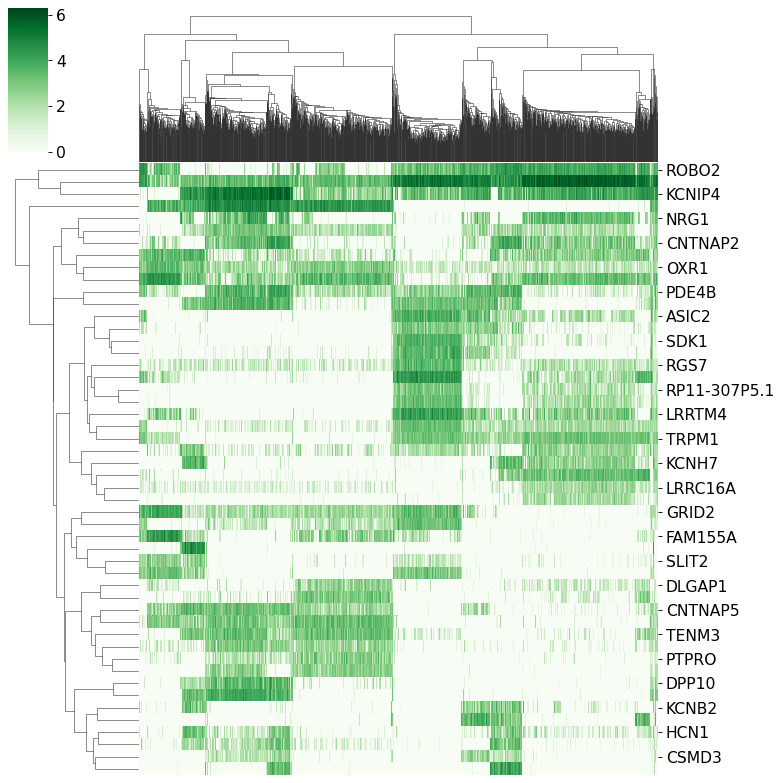

In [441]:
cell_type = 'BC'
grp = df_all[df_all['cell.type'] == cell_type] if cell_type != 'all' else df_all
print(cell_type, grp.shape)
grp['donor_cell_type_cluster'] = grp['donor'] + ':' + grp['leiden'] + ':' + grp['cell.type']
grp['found'] = 1
hm = grp.pivot('donor_cell_type_cluster', 'names', 'found').fillna(0)
genes = hm.sum(axis=0).sort_values().tail(50).index

ad2 = ad_donor[ad_donor.obs['scpred_prediction'] == cell_type,:]
ad2.shape
sns.clustermap(ad2.to_df()[genes].T, cmap='Greens', xticklabels=False)

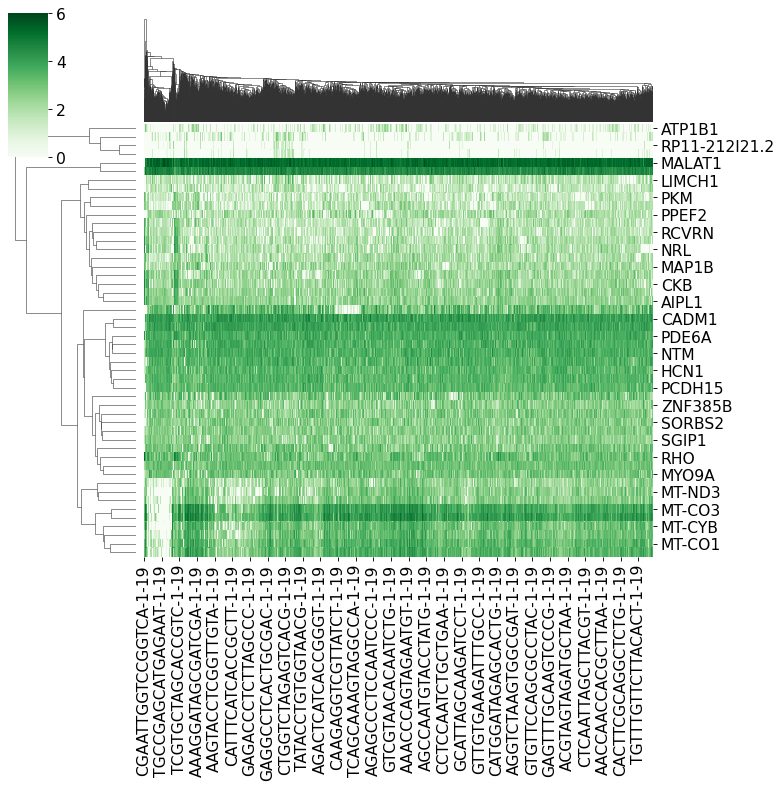

In [437]:
ad2 = ad_donor[ad_donor.obs['scpred_prediction'] == 'Rod',:]
ad2.shape
sns.clustermap(ad2.to_df()[genes].T, cmap='Greens')

In [425]:
sel_rod = sel[sel.obs['scpred_prediction'] == 'Rod',:]
sel_rod.shape
sns.clustermap(sel_rod.to_df()[genes].T, cmap='Greens')

(192327, 23797)

Rod (2200, 10)
donor # unique elements in category 20
20
leiden # unique elements in category 13
13
cell.type # unique elements in category 3
3
(220, 50)


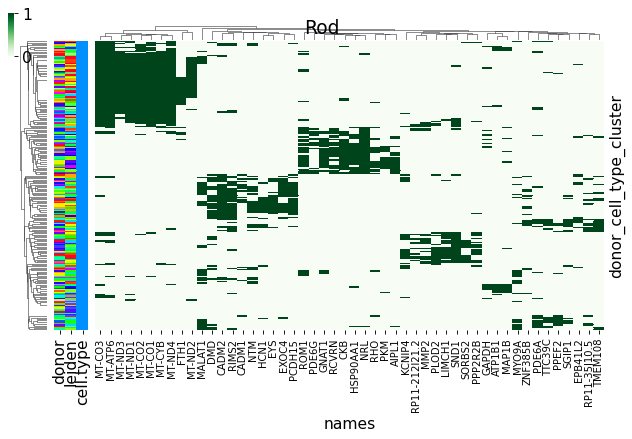

In [406]:
genes_all = set()
for cell_type in ['Rod', 'BC', 'AC', 'all']:
    grp = df_all[df_all['cell.type'] == cell_type] if cell_type != 'all' else df_all
    print(cell_type, grp.shape)
    grp['donor_cell_type_cluster'] = grp['donor'] + ':' + grp['leiden'] + ':' + grp['cell.type']
    grp['found'] = 1
    hm = grp.pivot('donor_cell_type_cluster', 'names', 'found').fillna(0)
    genes = hm.sum(axis=0).sort_values().tail(50).index
    
    if cell_type == 'all':
        genes = list(genes_all)
    else:
        for g in genes:
            genes_all.add(g)

    row_colors = pd.DataFrame(index=hm.index)
    row_colors
    for i, lab in enumerate(['donor', 'leiden', 'cell.type']):
        
        uniq_elem = grp[lab].unique() if lab != 'cell.type' else df[lab].unique()
        
        cm = plt.get_cmap('gist_rainbow')
        n_unique = len(uniq_elem)
        print(lab, '# unique elements in category', n_unique)
        colors = [cm(1.* i / n_unique) for i in range(n_unique)]
        print(len(colors))
        col_by_leiden = {xlab: c for xlab, c in zip(uniq_elem, colors)}
        row_colors[lab] = hm.index.str.split(':').str[i].map(col_by_leiden)
    print(hm[genes].shape)
    
    g = sns.clustermap(hm[genes], cmap='Greens', row_colors=row_colors, figsize=[8 if cell_type != 'all' else 17, 6 if cell_type != 'all' else 7], dendrogram_ratio=0.05,
                       yticklabels=False, xticklabels=True, cbar_pos=(0.01, 0.9, 0.01, 0.09), colors_ratio=0.02 if cell_type != 'all' else 0.01)
    g.fig.suptitle(cell_type) 
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 9)
    
    break

Rod (2200, 10)
donor # unique elements in category 20
20
leiden # unique elements in category 13
13
cell.type # unique elements in category 3
3
(220, 50)
BC (3230, 10)
donor # unique elements in category 20
20
leiden # unique elements in category 19
19
cell.type # unique elements in category 3
3
(323, 50)
AC (2850, 10)
donor # unique elements in category 20
20
leiden # unique elements in category 17
17
cell.type # unique elements in category 3
3
(285, 50)
all (8280, 10)
donor # unique elements in category 20
20
leiden # unique elements in category 49
49
cell.type # unique elements in category 3
3
(828, 136)


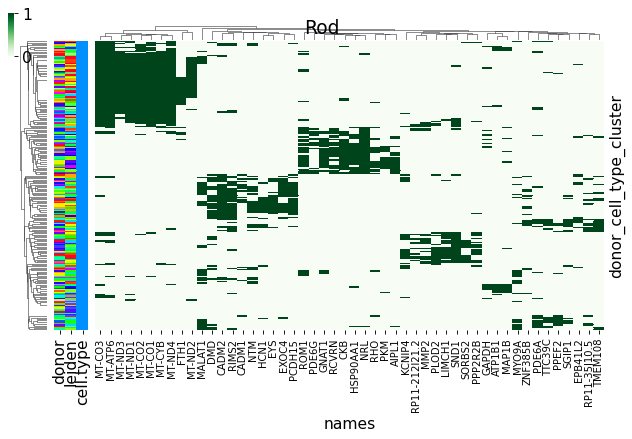

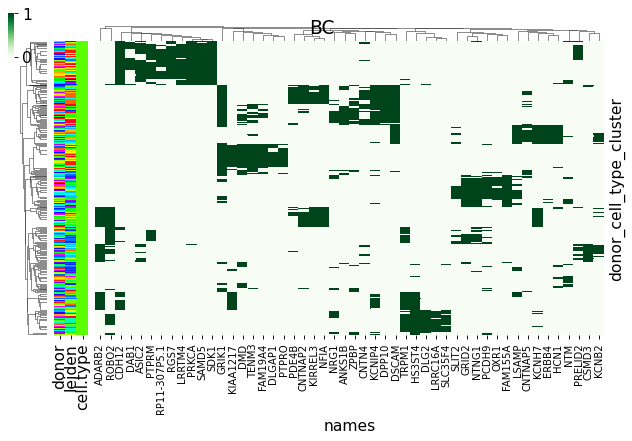

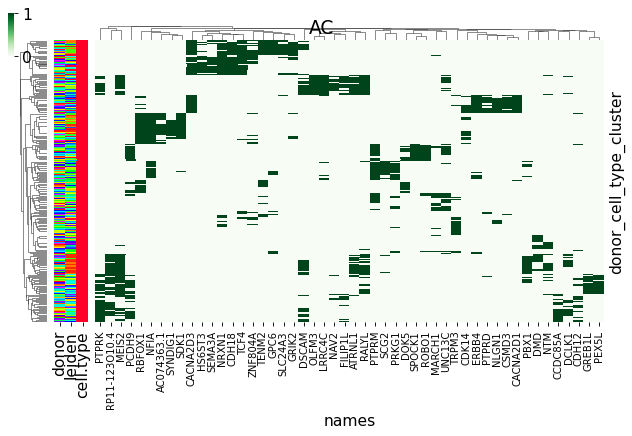

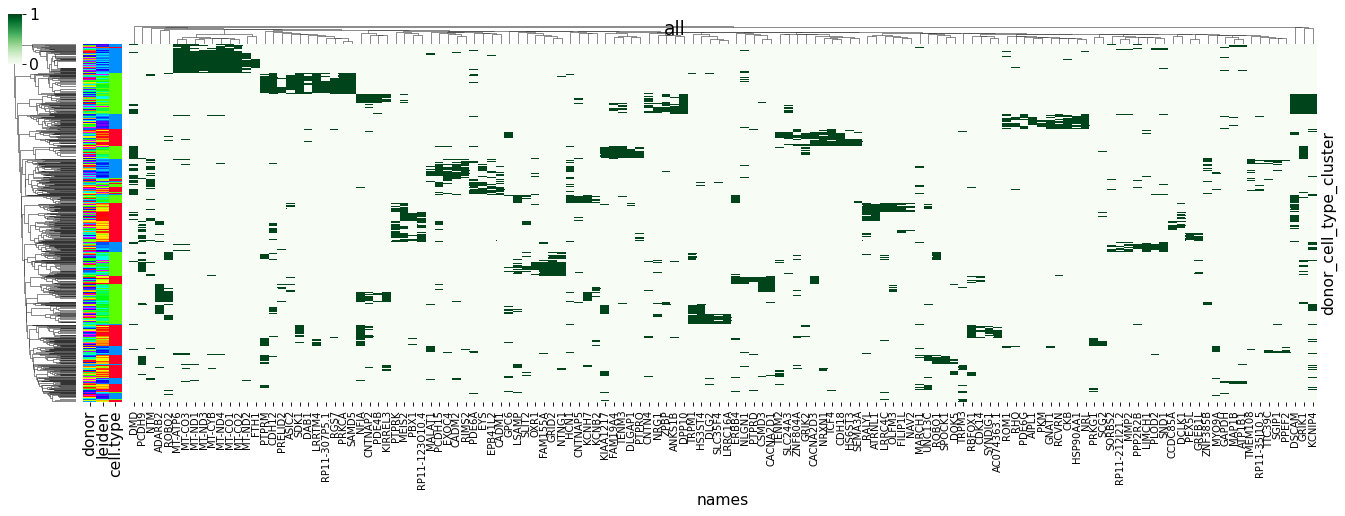

In [399]:
genes_all = set()
for cell_type in ['Rod', 'BC', 'AC', 'all']:
    grp = df_all[df_all['cell.type'] == cell_type] if cell_type != 'all' else df_all
    print(cell_type, grp.shape)
    grp['donor_cell_type_cluster'] = grp['donor'] + ':' + grp['leiden'] + ':' + grp['cell.type']
    grp['found'] = 1
    hm = grp.pivot('donor_cell_type_cluster', 'names', 'found').fillna(0)
    genes = hm.sum(axis=0).sort_values().tail(50).index
    
    if cell_type == 'all':
        genes = list(genes_all)
    else:
        for g in genes:
            genes_all.add(g)

    row_colors = pd.DataFrame(index=hm.index)
    row_colors
    for i, lab in enumerate(['donor', 'leiden', 'cell.type']):
        
        uniq_elem = grp[lab].unique() if lab != 'cell.type' else df[lab].unique()
        
        cm = plt.get_cmap('gist_rainbow')
        n_unique = len(uniq_elem)
        print(lab, '# unique elements in category', n_unique)
        colors = [cm(1.* i / n_unique) for i in range(n_unique)]
        print(len(colors))
        col_by_leiden = {xlab: c for xlab, c in zip(uniq_elem, colors)}
        row_colors[lab] = hm.index.str.split(':').str[i].map(col_by_leiden)
    print(hm[genes].shape)
    
    g = sns.clustermap(hm[genes], cmap='Greens', row_colors=row_colors, figsize=[8 if cell_type != 'all' else 17, 6 if cell_type != 'all' else 7], dendrogram_ratio=0.05,
                       yticklabels=False, xticklabels=True, cbar_pos=(0.01, 0.9, 0.01, 0.09), colors_ratio=0.02 if cell_type != 'all' else 0.01)
    g.fig.suptitle(cell_type) 
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 9)

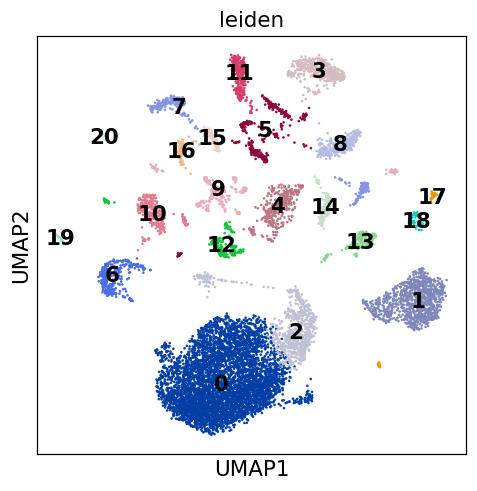

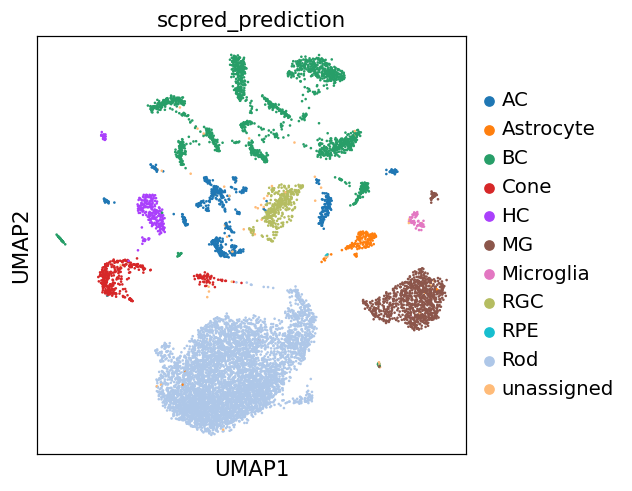

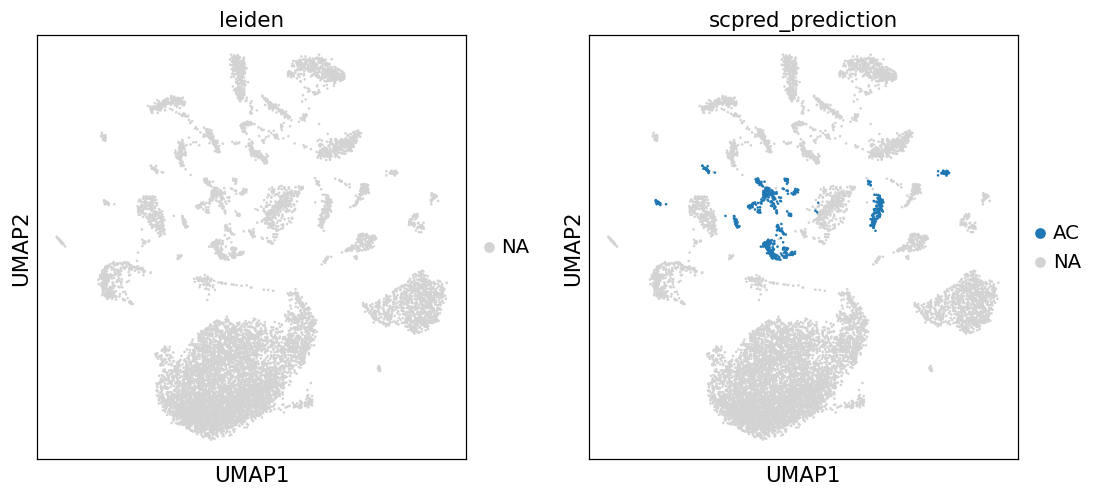

In [175]:
sc.tl.leiden(sel, resolution=.2)
sc.pl.umap(sel, color=['leiden'], legend_loc='on data')
sc.pl.umap(sel, color=['scpred_prediction'])
sc.pl.umap(sel, color=['leiden', 'scpred_prediction'], groups='AC')

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


9
10
12
14


In [194]:
df

,names,scores,logfoldchanges,pvals,pvals_adj,leiden
0,RP11-123O10.4,22.968016,4.453348,1.061753e-72,6.316632e-69,9
1,PBX1,19.841326,3.198771,3.819014e-62,1.298301e-58,9
2,GAD1,19.569773,3.249677,1.114021e-61,3.313796e-58,9
3,TJP1,19.459938,2.426496,5.336100e-63,2.116386e-59,9
4,ATRNL1,18.972660,2.737624,2.848558e-60,6.778713e-57,9
5,DCLK1,18.829376,3.247435,1.608794e-57,3.190374e-54,9
6,RALYL,18.424578,3.939798,2.994360e-54,4.197774e-51,9
7,ENOX1,17.707811,2.873166,2.998788e-54,4.197774e-51,9
8,MEIS2,17.532686,3.161183,7.422873e-52,9.296953e-49,9
9,NTM,17.523617,2.388297,4.685512e-55,7.433408e-52,9


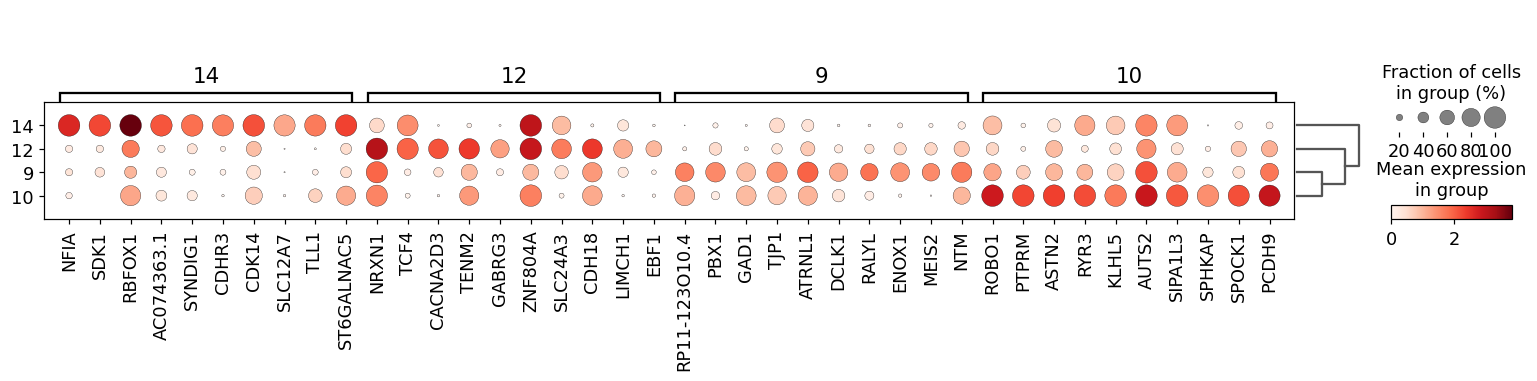

In [182]:
sc.pl.rank_genes_groups_dotplot(sel_ac)

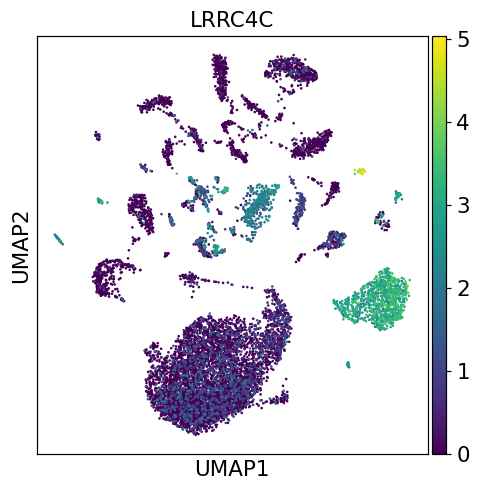

In [171]:
sc.pl.umap(sel, color='LRRC4C')

In [ ]:
import seaborn as sns
x = 'donor'
y = 'scpred_prediction'
from matplotlib import rcParams
rcParams['figure.dpi'] = 70
# donor and filename are exactly the same

hm = ad.obs.groupby([x, y]).size().reset_index().pivot(x, y, 0)
sns.clustermap(hm, cmap='Reds', annot=hm, fmt='', cbar_kws={'label': '# cells'})

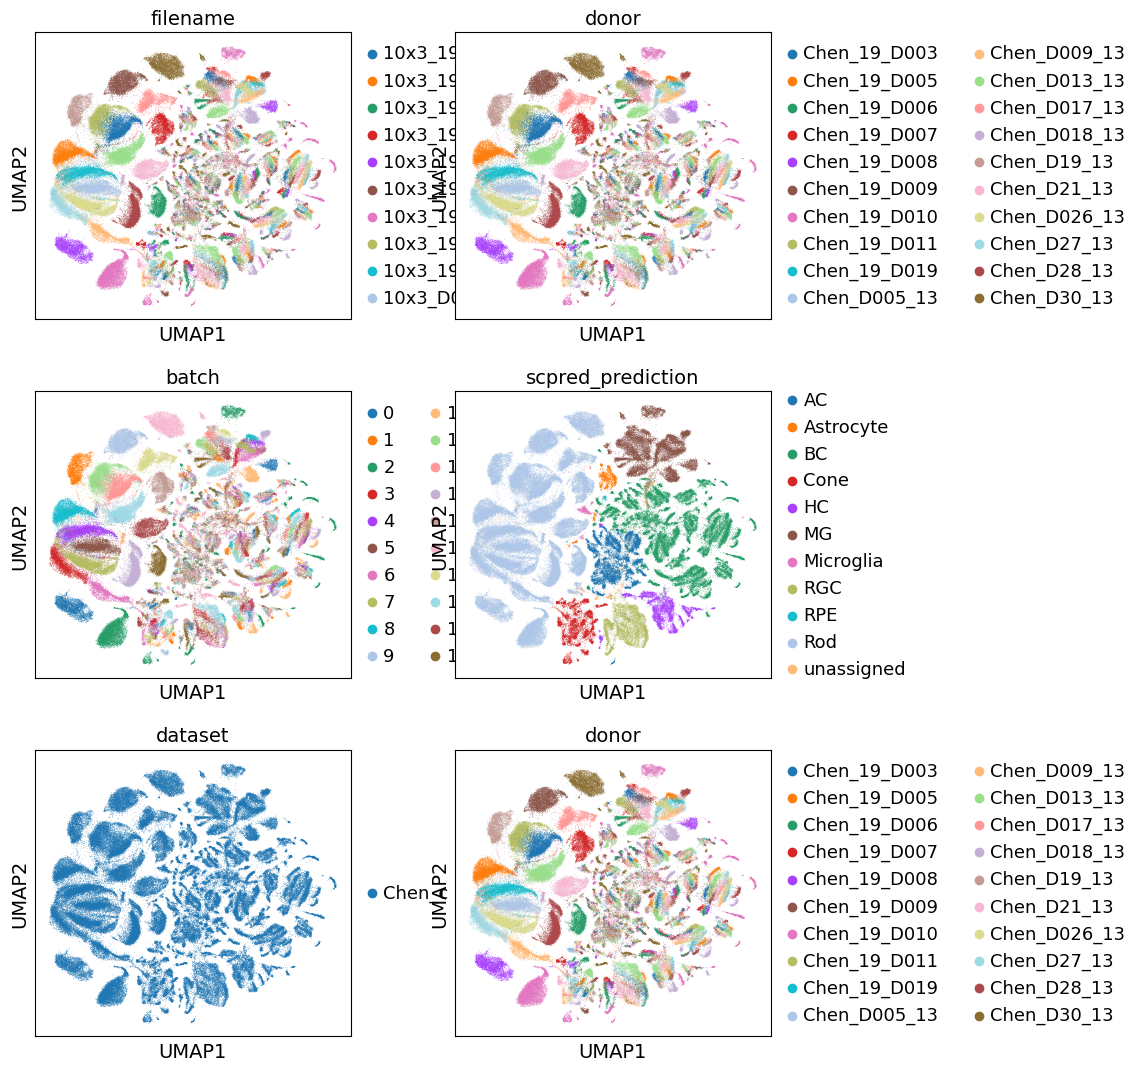

In [45]:
sc.pl.umap(ad, color=['filename', 'donor', 'batch', 'scpred_prediction', 'dataset'], ncols=2)